In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import Model

In [2]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
dataframe.shape

(4998, 141)

In [4]:
labels = raw_data[:,-1]

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data,labels,test_size=0.2, random_state=21)


In [5]:
min_value = tf.reduce_min(train_data)
max_value = tf.reduce_max(train_data)

train_data = (train_data - min_value)/(max_value - min_value)
test_data = (test_data - min_value)/(max_value - min_value)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

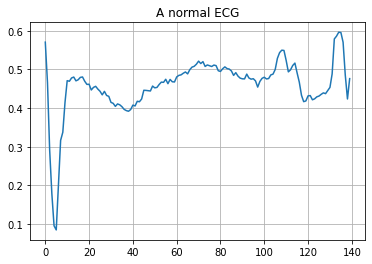

In [7]:
#plot a normal ECG
import matplotlib.pyplot as plt
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A normal ECG")
plt.show()

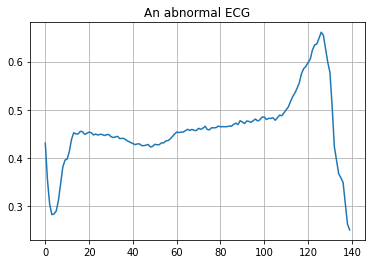

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An abnormal ECG")
plt.show()

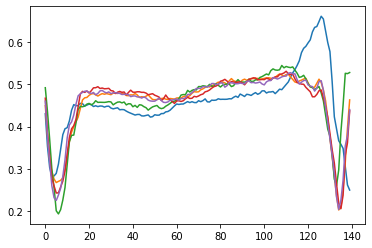

In [9]:
import seaborn as sns
for i in range(5):
    #sns.lineplot(normal_train_data[i])
    sns.lineplot(anomalous_train_data[i])

In [10]:
# Build the model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(32, activation ="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu")
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(140, activation = "sigmoid")
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer = 'adam', loss='mae')

In [12]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs = 20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0583 - val_loss: 0.0534
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0563 - val_loss: 0.0521
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0542 - val_loss: 0.0506
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0514 - val_loss: 0.0492
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0481 - val_loss: 0.0475
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0444 - val_loss: 0.0456
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0407 - val_loss: 0.0432
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0372 - val_loss: 0.0416
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0341 - val_loss: 0.0403
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0317 - val_loss: 0.0391
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0297 - val_loss: 0.0384
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0282 - val_loss: 0.0377
E

In [13]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

53/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


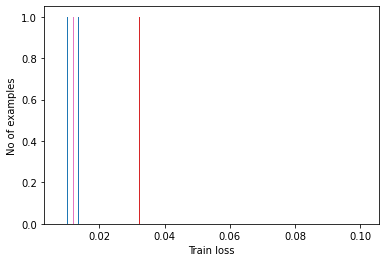

In [14]:
plt.hist(train_loss , bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()